Copyright © 2024 Xiaohan Dan(xiaohan.dan@yale.edu), Saurabh Baswaraj Shivpuje(sshivpuj@purdue.edu), Yuchen Wang(wang3602@purdue.edu)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Tutorial on quantum algorithm with the Lindblad Master Equation

Here, we provide the code for a general quantum algorithm simulating open quantum dynamics on IBM quantum Aer simulator.

# Importing Libraries
The four major libraries imported for this code are:
* "numpy" for all matrix related numerical calculations
* "scipy" for calculating square root of matrix
* "matplotlib" for generating plots from results obtained
* "qiskit" for all types of quantum implementation

In [1]:
!pip install qiskit==1.0.2
!pip install qiskit_aer==0.14.0.1
!pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 50.9 MB/s eta 0:00:00


#The Parameters and Utility functions

In [2]:
import numpy as np
import scipy.linalg as LA

In [3]:
class Params:
    # Pauli matrices
    X = np.array([[0, 1], [1, 0]], dtype=np.complex_)
    Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex_)
    Z = np.array([[1, 0], [0, -1]], dtype=np.complex_)
    I = np.eye(2, dtype=np.complex_)

    # sigma+ and sigma-
    sigmap = 0.5*(X+1j*Y)
    sigmam = 0.5*(X-1j*Y)

    # Spin-up and spin-down states
    spin_up = np.array([1.0, 0.0], dtype=np.float_)
    spin_down = np.array([0.0, 1.0], dtype=np.float_)

    #some constant to convert the units
    au2fs    = 2.418884254E-2
    au2cm    = 219474.63068
    au2joule = 4.35974381E-18
    bolz     = 1.3806503E-23
    au2ev    = 27.2114
    hbar     = 1.0

pa = Params()

##The transformation between Pauli string and Hamiltonian matrix


In [4]:
def nested_kronecker_product(pauli_str):
    '''
    Handles Kronecker Products for list (i.e., pauli_str = 'ZZZ' will evaluate Z Z Z).
    Given string 'pauli_str' this evaluates the kronecker product of all elements.
    '''

    # Define a dictionary with the four Pauli matrices:
    pms = {'I': pa.I,'X': pa.X,'Y': pa.Y,'Z': pa.Z}

    result = 1
    for i in range(len(pauli_str)):
     result = np.kron(result,pms[pauli_str[i]])
    return result


def pauli_to_ham(pauli_dict, Nqb):
    '''
        Function that Assembles the Hamiltonian based on their Pauli string

        pauli_dict: A dictionary that contain all the pauli string and the value of the Hamiltonian
            (the key is pauli string and the value is coefficient)

        Nqb: number of qubits, should match the length of the pauli string

        return: Hamiltonian matrix
    '''

    Hmat = np.zeros((2**Nqb,2**Nqb),dtype=np.complex128)
    for key in pauli_dict:
        Hmat += pauli_dict[key]*nested_kronecker_product(key)

    return Hmat

def ham_to_pauli(Ham_arr, Nqb, tol=1E-5):
    '''
    Function that decomposes `Ham_arr` into a sum of Pauli strings.
    result: a dictionary with the key is pauli string and the value is coefficient
    '''
    import itertools

    pauli_keys = ['I','X','Y','Z'] # Keys of the dictionary

    if(2**Nqb != Ham_arr.shape[0]):
        print('Nqb and Matrix size not matched!')

    # Make all possible tensor products of Pauli matrices sigma
    sigma_combinations = list(itertools.product(pauli_keys, repeat=Nqb))

    result = {} # Initialize an empty dictionary to the results
    for ii in range(len(sigma_combinations)):
        pauli_str = ''.join(sigma_combinations[ii])

        # Evaluate the Kronecker product of the matrix array
        tmp_p_matrix = nested_kronecker_product(pauli_str)

        # Compute the coefficient for each Pauli string
        a_coeff = (1/(2**Nqb)) * np.trace(tmp_p_matrix @ Ham_arr)

        # If the coefficient is non-zero, we want to use it!
        if abs(a_coeff) > tol:
            result[pauli_str] = a_coeff.real

    return result

#Quantum algorithm for open system dynamics

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

##Sz.-Nagy dilation

In [6]:
def dilate(array,Isscale=True):

  if(Isscale):
    # Normalization factor, 1.1 times martix's norm to ensure contraction
    norm = LA.norm(array,2)*1.1
    array_new = array/norm
  else:
    array_new = array

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = LA.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = LA.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])
  if(Isscale):
    return array_dilated, norm
  else:
    return array_dilated

##Functions that calculating Kraus operators from the propagator matrix

In [7]:
def gen_Kraus_list(Gmat,N,tol=1E-5):
  """
    Generate the Kraus operators from the propagator with a given tolerance
    Input:
    - Gmat: matrix of the propagator (numpy array of shape (N^2, N^2)).
    - N: The system Hilbert space dimension
    - tol: tolerance for the Kraus operator representation.
    Returns:
    - Kraus: List of Kraus operators
  """
  #defining the Choi matrix from the matrix of the propagator
  C_mat = np.zeros(Gmat.shape,dtype=np.complex_)
  for i in range(N):
    for j in range(N):
      C_matij = np.zeros(Gmat.shape,dtype=np.complex_)
      for k in range(N):
        for l in range(N):
          C_matij[i*N+k,l*N+j] = Gmat[j*N+k,l*N+i]
      C_mat += C_matij

  Kraus = []
  val,arr = LA.eigh(C_mat)
  for i in range(len(val)):
    if(val[i]>tol):
      Mi = np.sqrt(val[i])*arr[:,i].reshape(N,N)
      Kraus.append(Mi.conj().T)
  return Kraus

# Simulating the Lindblad Master Equation on Digital Computers

## Matrix exponential: the propagator of the Lindblad equation

By representing the density matrix in the vectorized form:
$$
    \rho \to |\nu_{\rho} \rangle= \left[ \rho_{11}, \ldots, \rho_{1N}, \rho_{21}, \ldots, \rho_{2N}, \ldots, \rho_{N1}, \ldots, \rho_{NN} \right]^T,
$$

The time-evolution of the Lindblad equation can be represented as
\begin{equation}
    | \nu_{\rho}(t)\rangle = \mathbf{G}(t)  
    | \nu_{\rho}(0)\rangle ~~.
\end{equation}
where the $\mathbf{G}(t)$ is the propagator and $\mathbf{G}(t)  = e^{-i H_{\mathrm{eff}} t}$,
with the $H_{\mathrm{eff}}$ is defined by $H_{\mathrm{eff}} = H_C + iH_D$:
\begin{equation}
\begin{split}
    H_C &= H \otimes \mathbb{I}-\mathbb{I} \otimes H^T ~~,\\
    H_D &= \sum_{n} \frac{i}{2} \gamma_{n} \left[ 2L_{n}\otimes L^*_{n} - \mathbb{I}\otimes L^T_{n} L^*_{n} - L^\dagger_{n} L_{n} \otimes \mathbb{I}
    \right] ~~,
\end{split}
\end{equation}

Thus, the Lindblad equation can be solved by first calculated the propagator through matrix exponential, then performing matrix-vector multiplication

In [8]:
def Gt_matrix_expo(H, L, time_arr, Is_show_step = False):
    """
    Getting the propagator of the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    Returns:
    - G_prop: List of propagators.
    """
    Nsys = H.shape[0]
    ident_h = np.eye(Nsys, dtype=np.complex_)

    # Amatrix for time-derivation of the vectorized density matrix
    Amat = -1j * (np.kron(H, ident_h) - np.kron(ident_h, H.T))
    for i in range(len(L)):
      Amat += 0.5 * (2.0 * (np.kron(L[i], L[i].conj()))
                           - np.kron(ident_h, L[i].T @ L[i].conj())
                           - np.kron(L[i].T.conj() @ L[i], ident_h))

    G_prop = []
    for i in range(len(time_arr)):
        if(Is_show_step): print('step',i,'time',time_arr[i])
        Gt = LA.expm(Amat * time_arr[i])
        G_prop.append(Gt)
    return G_prop

def propagate_matrix_exp(H, rho0, time_arr, L, observable, Is_store_state = False, Is_show_step = False, Is_Gt = False):
    """
    Solving the Lindblad equation by matrix exponential
    Parameters:
    - H: Hamiltonian of the system (numpy array of shape (N, N)).
    - rho0: Initial density matrix (numpy array of shape (N, N)).
    - time_arr: Time array for dynamic simulation (array).
    - L: List of Collapse operators, with each operator is a numpy array of shape (N, N).
    - observable: Observable for which the expectation value is computed (numpy array of shape (N, N)).
    - Is_store_state: Boolean variable that determines whether to output the density matrix list
    - show_step: Boolean variable that determines whether to print the current step during simulation
    Returns:
    - result: A class containing all the results
      result.expect: List of expectation values of the observable over time.
      result.G_prop: List of propagators.
      result.density_matrix: List of density matrices.
    """
    class Result:
      def __init__(self):
        self.expect = []
        if(Is_store_state):
          self.density_matrix = []
        if(Is_Gt):  self.Gprop = None
    result = Result()

    # Getting the propagator of the Lindblad equation
    G_prop = Gt_matrix_expo(H, L, time_arr, Is_show_step)
    if(Is_Gt):  result.Gprop = G_prop

    # initialized vectorized density matrix
    Nsys = H.shape[0]
    vec_rho0 = rho0.reshape(Nsys**2)

    for i in range(len(time_arr)):

        vec_rhot = G_prop[i] @ vec_rho0

        # get the density matrix by reshaping
        rhot = vec_rhot.reshape(Nsys, Nsys)

        if(Is_store_state):  result.density_matrix.append(rhot)
        result.expect.append(np.trace(rhot @ observable).real)

    return result

##QuTiP solver

In [9]:
from qutip import mesolve, Qobj

def qutip_prop(H, rho0, time_arr, c_ops, observable):
    """
    First import the mesolve function, which is used to solve master equations, and the Qobj class, which is used to represent quantum objects, from the QuTiP library.
    - H: Hamiltonian of the system (Qobj).
    - rho0: Initial density matrix (Qobj).
    - time_arr: Time array for dynamic simulation (array).
    - c_ops: List of collapse operators (list of Qobj), can be empty for Liouville equation.
    - observable: Operator for which the expectation value is to be calculated (Qobj).
    Returns:
    - expec_vals: List of expectation values of the observable over time.
    """
    result = mesolve(H, rho0, time_arr, c_ops, observable)
    return result.expect


# The Spin-1/2 system

## Classical simulation

In [10]:
# The Spin-1/2 system Hamiltonian
H_1spin = 2 * np.pi * 0.1 * pa.X

# The jump operator and damping rate of Spin-1/2 system
gamma_1spin = 0.05
L_1spin = np.sqrt(gamma_1spin)*pa.X

# Initial density matrix
rho0_1spin = np.outer(pa.spin_up, pa.spin_up.conj())

# Time array for simulation
time_arr = np.linspace(0, (250 - 1) * 0.1, 250)

In [11]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(H_1spin, rho0_1spin, time_arr, [L_1spin], pa.Z)

# QuTiP Propagation for Liouville equation (no collapse operator)
expec_vals_qutip_Liouv = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [], Qobj(pa.Z))

# QuTiP Propagation for Lindblad equation
expec_vals_qutip_Lindblad = qutip_prop(Qobj(H_1spin), Qobj(rho0_1spin), time_arr, [Qobj(L_1spin)], Qobj(pa.Z))

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


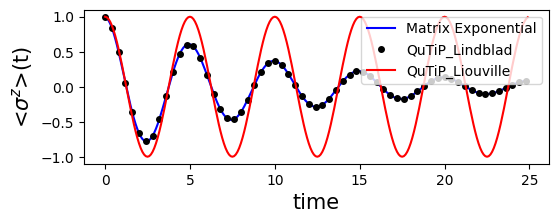

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.plot(time_arr, result_matrix_exp.expect,'b-', label = "Matrix Exponential")
plt.plot(time_arr, expec_vals_qutip_Lindblad[0],'ko',markersize=4,markevery=4, label = "QuTiP_Lindblad")
plt.plot(time_arr, expec_vals_qutip_Liouv[0],'r-', label = "QuTiP_Liouville")
plt.xlabel('time',fontsize=15)
plt.ylabel('<$\sigma^z$>(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Quantum Simulation of the Spin-1/2 system: Amplitude-channel damping

In [13]:
gamma = 1.52e9*1E-12 # the spontaneous emission rate, ps^-1
time_sdam = np.arange(0, 1000, 1) #time array, from t=0 to t=1000 ps
Nsys_1spin = 2

#defining the initial density matrix rho
rho0_sdam = np.array([[1/4,1/4],[1/4,3/4]],dtype=np.complex_)
vec0_sdam = rho0_sdam.reshape(Nsys_1spin**2)
norm0_sdam = LA.norm(vec0_sdam,2)
vec0_sdam /= norm0_sdam

Pop_Mexp = np.zeros((len(time_sdam),2),dtype=np.float_) #population array

Gprop_sdam = Gt_matrix_expo(0.0*pa.X, [np.sqrt(gamma)*pa.sigmap], time_sdam)

for i in range(len(time_sdam)):

  Gt = Gprop_sdam[i]
  rhot_sdam = (Gt@vec0_sdam).reshape(Nsys_1spin,Nsys_1spin)*norm0_sdam
  Pop_Mexp[i,0] = rhot_sdam[0,0].real
  Pop_Mexp[i,1] = rhot_sdam[1,1].real

In [14]:
# initial state in the dilated space
rho0_sdam_dil = np.concatenate((vec0_sdam,np.zeros(Nsys_1spin**2)))

aersim = AerSimulator()
shots = 2000
Pop_qc = np.zeros((len(time_sdam),2),dtype=np.float_)

for i in range(len(time_sdam)):
    if(i%100==0):print('istep',i)
    qr = QuantumRegister(2+1)  # Create a quantum register
    cr = ClassicalRegister(2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sdam_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sdam[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)
    # Apply the unitary operator to the quantum circuit's qubits and measure
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)

    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    if '011' and '000' in counts1:
      Pop_qc[i,0] = np.sqrt(counts1['000']/shots)*norm*norm0_sdam
      Pop_qc[i,1] = np.sqrt(counts1['011']/shots)*norm*norm0_sdam
    else:
      print(i,'shots=',shots,"no counts for up state")

istep 0
istep 100
istep 200
istep 300
istep 400
istep 500
istep 600
istep 700
istep 800
istep 900


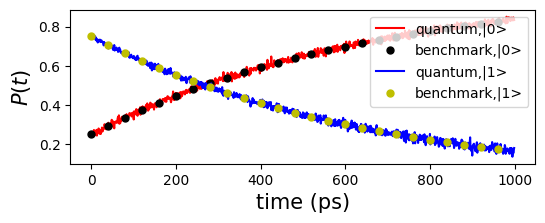

In [15]:
plt.figure(figsize=(6,2))
plt.plot(time_sdam,Pop_qc[:,0],'r-',label="quantum,|0>")
plt.plot(time_sdam,Pop_Mexp[:,0],'ko',markersize=5,markevery=40,label="benchmark,|0>")
plt.plot(time_sdam,Pop_qc[:,1],'b-',label="quantum,|1>")
plt.plot(time_sdam,Pop_Mexp[:,1],'yo',markersize=5,markevery=40,label="benchmark,|1>")
plt.xlabel('time (ps)',fontsize=15)
plt.ylabel('$P(t)$',fontsize=15)
plt.legend(loc = 'upper right')

#The spin-chain

## The system Hamiltonian and initial state

In [16]:
#the system Hamiltonian parameter
nsite = 3 #this states how many spins in the simulation
Nsys_sc = 2**nsite #this is the dimension of the Hilbert space
Omegai_list = [0.65, 1.0, 1.0]
Jix_list = [0.75, 1.0]
Jiy_list = [0.75, 1.0]
Jiz_list = [0.0, 0.0]

#set up the initial state at [up,down,down...]
init_state = pa.spin_up
for i in range(nsite-1):
  init_state = np.kron(init_state,pa.spin_down)

#set up the initial density matrix according to initial state
rho0_sc = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
rho0_sc += np.outer(init_state,init_state.conj())

#time array for simulation
nsteps = 250
time_arr = np.linspace(0, (nsteps - 1) * 0.1, nsteps)

In [17]:
#the diagnoal part of the Hamiltonian
H_diag = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
for n in range(nsite):
    tmp = 1.0
    for i in range(nsite):
      if(i==n):
        tmp = np.kron(tmp,pa.Z)
      else:
        tmp = np.kron(tmp,pa.I)
    H_diag += Omegai_list[n]*tmp

#the non-diagnoal (coupling) part of the Hamiltonian
H_coup = np.zeros((Nsys_sc,Nsys_sc),dtype=np.complex_)
XX = np.kron(pa.X,pa.X)
YY = np.kron(pa.Y,pa.Y)
ZZ = np.kron(pa.Z,pa.Z)
for n in range(nsite-1):
  coup_tmp = Jix_list[n]*XX+Jiy_list[n]*YY+Jiz_list[n]*ZZ
  tmp = 1.0
  for i in range(nsite-1):
    if(n==i):
      tmp = np.kron(tmp,coup_tmp)
    else:
      tmp = np.kron(tmp,pa.I)
  H_coup += tmp
Hsys_sc = H_diag - 0.5 * H_coup
Hsys_sc_qobj = Qobj(Hsys_sc)

## Setup the Lindbladian

In [18]:
#The lindblad damping rate
Gamma1 = [0.016]*nsite
Gamma2 = [0.0523]*nsite

#The Collapse operators
L_sc = []
L_sc_qobj = [] #this stores Qobj type for QuTiP methods

sigma2 = pa.sigmap@pa.sigmam

for isite in range(nsite):
  #Lindbladian for type 1
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,pa.sigmam)*np.sqrt(Gamma1[isite])
    else:
      res = np.kron(res,pa.I)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

  #Lindbladian for type 2
  res = 1.0
  for j in range(nsite):
    if(j==isite):
      res = np.kron(res,sigma2)*np.sqrt(Gamma2[isite])
    else:
      res = np.kron(res,pa.I)
  L_sc.append(res)
  L_sc_qobj.append(Qobj(res))

## Spin-chain Dynamics: Matrix Exponential Propagation and QuTiP solver

In [19]:
# Matrix Exponential Propagation
result_matrix_exp = propagate_matrix_exp(Hsys_sc, rho0_sc, time_arr, L_sc, rho0_sc)

rho0_sc_qobj = Qobj(rho0_sc)
# QuTiP Propagation for Liouville equation (no collapse operator)
result_qutip_Liouv = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, [], rho0_sc_qobj)

# QuTiP Propagation for Lindblad equation
result_qutip_Lindblad = qutip_prop(Hsys_sc_qobj, rho0_sc_qobj, time_arr, L_sc_qobj, rho0_sc_qobj)

As_matrix_exp = np.sqrt(result_matrix_exp.expect[:])
As_qutip = np.sqrt(result_qutip_Lindblad[0][:])
As_qutip_liouv = np.sqrt(result_qutip_Liouv[0][:])

### Plot the Spin-chain dynamics

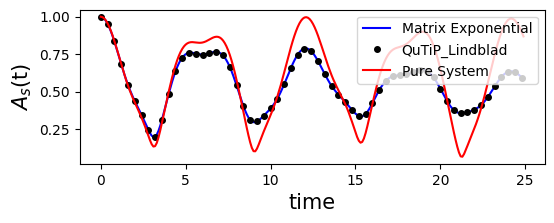

In [20]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_matrix_exp,'b-', label="Matrix Exponential")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP_Lindblad")
plt.plot(time_arr,As_qutip_liouv,'r-',label="Pure System")
plt.xlabel('time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Quantum simulation of the spin chain

In [21]:
# initial state of the spin chain in the dilated space
# rho0_sc=|up,down,...><up,down,...|, has defined in the Digital computer simulation part
rho0_sc_dil = np.concatenate((rho0_sc.reshape(Nsys_sc**2),np.zeros(Nsys_sc**2)))

# The propagator of the spin chain Lindblad equation
Gprop_sc = Gt_matrix_expo(Hsys_sc, L_sc, time_arr)

aersim=AerSimulator()
shots_arr = [1000,10000]
As_qc_1k = np.zeros((nsteps),dtype=np.float_)
As_qc_1w = np.zeros((nsteps),dtype=np.float_)
As_qc = [As_qc_1k,As_qc_1w]
nsteps = len(time_arr)

for i in range(nsteps):
    if(i%10==0):print('istep',i)
    qr = QuantumRegister(nsite*2+1)  # Create a quantum register
    cr = ClassicalRegister(nsite*2+1)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_sc_dil, qr)
    # Dilated propagator
    U_G, norm = dilate(Gprop_sc[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)

    qc.measure(qr, cr)

    for ishot in range(len(shots_arr)):
        counts1 = aersim.run(qc,shots=shots_arr[ishot]).result().get_counts()
        if '0011011' in counts1:
          survi_amp = np.sqrt(counts1['0011011']/shots_arr[ishot])*norm
          As_qc[ishot][i] = np.sqrt(survi_amp)
        else:
          print(i,'shots=',shots_arr[ishot],"no counts")


istep 0
istep 10
istep 20
istep 30
33 shots= 1000 no counts
istep 40
istep 50
istep 60
istep 70
istep 80
istep 90
istep 100
istep 110
istep 120
istep 130
istep 140
istep 150
istep 160
istep 170
istep 180
istep 190
istep 200
istep 210
istep 220
istep 230
istep 240


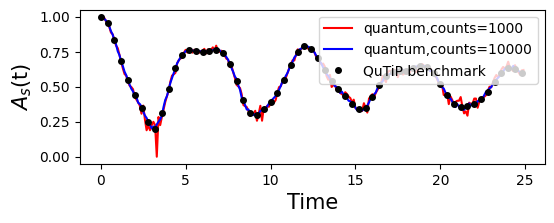

In [22]:
plt.figure(figsize=(6,2))
plt.plot(time_arr,As_qc_1k[:],'r-',label=f"quantum,counts={1000}")
plt.plot(time_arr,As_qc_1w[:],'b-',label=f"quantum,counts={10000}")
plt.plot(time_arr,As_qutip,'ko',markersize=4,markevery=4,label="QuTiP benchmark")
plt.xlabel('Time',fontsize=15)
plt.ylabel('$A_s$(t)',fontsize=15)
plt.legend(loc = 'upper right')

#Double Well

##Setup the double-well potential

In [23]:
def pot_doublewell(x, f=0.0367493, a0=0.0, a1=0.429, a2=-1.126, a3=-0.143, a4=0.563):
    # A-T pair double-well potential in Hartrees (x is in Bohr)
    xi = x/1.9592
    return f*(a0 + a1*xi + a2*xi**2 + a3*xi**3 + a4*xi**4)

In [24]:
#The parameters
#Note that some unit conversion constants are defined in the pa object (an implementation of the Params class)
mass0 = 1836.15
beta = pa.au2joule/(pa.bolz*300) #1/(kT) in a.u. units
omega = 0.00436 #the frequency associate with the right well
kappa = 1/(10/pa.au2fs)
nth = 1/(np.exp(beta*omega)-1)

#set up the grid point
xmin = -4.0
xmax = 4.0
ndvr = 1024
xgrid = np.linspace(xmin,xmax,ndvr)

pot_arr = pot_doublewell(xgrid)

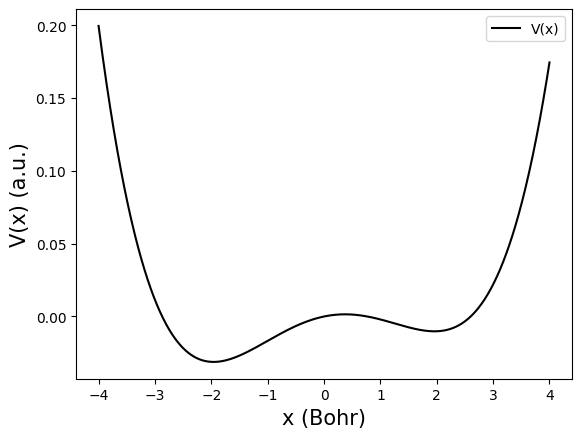

In [25]:
plt.plot(xgrid,pot_arr,'k', label = "V(x)")
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('V(x) (a.u.)',fontsize=15)
plt.legend(loc = 'upper right')

##calculate the eigenstate

In [26]:
import scipy.linalg as LA

def get_eig_state(hamk,pot,xgrid,Nstate):
    """
    get the eigen state for potential in x-space
    input:kinetic energy hamiltonian, potential in x-space
    """
    Mata = hamk.copy()
    for i in range(ndvr):
        Mata[i,i]+=pot[i]

    val,arr = LA.eigh(Mata)
    dx = xgrid[1]-xgrid[0]
    return val[:Nstate],arr[:,:Nstate]/dx**0.5

In [27]:
import scipy.fft as sfft
kgrid = np.zeros(ndvr,dtype=np.float64)
#ak2: kinetic energy array in k-space
ak2   = np.zeros(ndvr,dtype=np.float64)

dx = xgrid[1]-xgrid[0]
dk = 2.0*np.pi/((ndvr)*dx)
coef_k = pa.hbar**2/(2.0*mass0)

for i in range(ndvr):
  if(i<ndvr//2):
    kgrid[i] = i*dk
  else:
    kgrid[i] = -(ndvr-i) * dk

  ak2[i] = coef_k*kgrid[i]**2

akx0 = sfft.ifft(ak2)
#hamk: kinetic hamiltonian Matrix in position x grid space
hamk = np.zeros((ndvr,ndvr),dtype=np.complex128)

for i in range(ndvr):
  for j in range(ndvr):
    if(i<j):
      hamk[i,j] = akx0[i-j].conj()
    else:
      hamk[i,j] = akx0[i-j]

In [28]:
Neig = 50
eneg_DW,psi_DW = get_eig_state(hamk,pot_arr,xgrid,Neig)

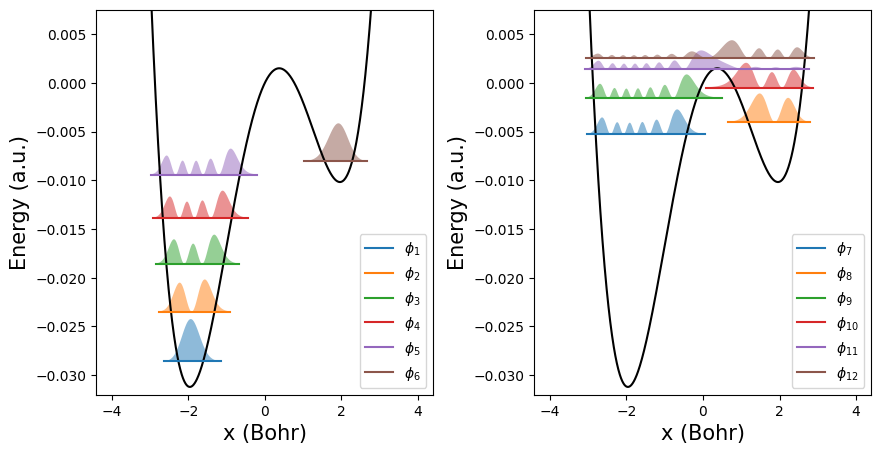

In [29]:
#plot the eigenenergy and the distribution

#distribution
dis = []
for i in range(Neig):
  dis.append(abs(psi_DW[:,i])**2)

x_arr1 = {}
eig_arr1 = {}
dis_plot = {}

for i in range(Neig):
  x_arr1[i]=[]
  eig_arr1[i] = []
  dis_plot[i] = []
  for j in range(len(xgrid)):
    if(abs(dis[i][j])>1E-2):
      x_arr1[i].append(xgrid[j])
      eig_arr1[i].append(eneg_DW[i])
      dis_plot[i].append(dis[i][j])
  dis_plot[i] = np.array(dis_plot[i])

#plot
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(xgrid,pot_arr,'k')

const = 0.0025
for i in range(6):
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')

plt.subplot(122)
plt.plot(xgrid,pot_arr,'k')
for i in range(6,12):
  #plt.plot(x_arr1[i],(dis_plot[i]*const+eneg_DW[i]))
  plt.plot(x_arr1[i],eig_arr1[i],label=rf'$\phi_{{{i+1}}}$')
  plt.fill_between(x_arr1[i], (dis_plot[i]*const+eneg_DW[i]), eig_arr1[i],alpha=0.5)

plt.subplots_adjust(wspace=0.3)
plt.ylim((-0.032, 0.0075))
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('Energy (a.u.)',fontsize=15)
plt.legend(loc = 'lower right')

##Express the operators in terms of eigenstate basis


In [30]:
#the eigenstate in the k-space representation
#(by Fourier transform of the original eigenstate in x-space)
psik_DW = np.zeros((ndvr,Neig),dtype=np.complex_)
pre_fac = dx/(2*np.pi)**0.5
for i in range(Neig):
  psik_DW[:,i] = sfft.fft(psi_DW[:,i])*pre_fac

#initial density matrix
ini_occu = np.zeros(Neig,dtype=np.complex_)
ini_occu[5] = 1.0
rho0 = np.outer(ini_occu,ini_occu.conj())

#The operator in the eigenstate
xmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
pmat_eig = np.zeros((Neig,Neig),dtype=np.complex_)
for i in range(Neig):
  for j in range(Neig):
    xmat_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),xgrid),psi_DW[:,j])*dx
    pmat_eig[i,j] = np.dot(np.multiply(psik_DW[:,i].conj(),kgrid),psik_DW[:,j])*dk

#hamiltonian
H_dw = np.diag(eneg_DW)
#creation/annihilation operator
amat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)+1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)
adegmat_eig = xmat_eig.copy()*np.sqrt(mass0*omega/2)-1j*pmat_eig.copy()/np.sqrt(mass0*omega*2)

In [31]:
#define the population on the left/right well
x_barrier = 0.37321768
P_R = np.heaviside(xgrid-x_barrier,1)
P_L = 1 - np.heaviside(xgrid-x_barrier,1)

P_R_eig = np.zeros((Neig,Neig),dtype=np.complex_)
P_L_eig = np.zeros((Neig,Neig),dtype=np.complex_)
for i in range(Neig):
  for j in range(Neig):
    P_R_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_R),psi_DW[:,j])*dx
    P_L_eig[i,j] = np.dot(np.multiply(psi_DW[:,i].conj(),P_L),psi_DW[:,j])*dx

##Propogate the dynamics

In [32]:
#propogate using QuTiP
gamma1 = np.sqrt(kappa*(nth+1))
gamma2 = np.sqrt(kappa*(nth))
time_qtp = np.linspace(0,1000/pa.au2fs,20000)

#run the dynamics with different eigenstates truncation
result_qtp = {}
for N_eig_use in [20,30,40]:
  c_ops = [gamma1*Qobj(amat_eig[:N_eig_use,:N_eig_use]), gamma2*Qobj(adegmat_eig[:N_eig_use,:N_eig_use])]
  obs = [Qobj(P_R_eig[:N_eig_use,:N_eig_use]), Qobj(P_L_eig[:N_eig_use,:N_eig_use])]
  result_qtp[N_eig_use] = mesolve(Qobj(H_dw[:N_eig_use,:N_eig_use]), Qobj(rho0[:N_eig_use,:N_eig_use]), time_qtp, c_ops, obs, progress_bar=True).expect

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:479: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


10.0%. Run time:   0.49s. Est. time left: 00:00:00:04
20.0%. Run time:   0.91s. Est. time left: 00:00:00:03
30.0%. Run time:   1.32s. Est. time left: 00:00:00:03
40.0%. Run time:   1.77s. Est. time left: 00:00:00:02
50.0%. Run time:   2.24s. Est. time left: 00:00:00:02
60.0%. Run time:   2.69s. Est. time left: 00:00:00:01
70.0%. Run time:   3.12s. Est. time left: 00:00:00:01
80.0%. Run time:   3.53s. Est. time left: 00:00:00:00
90.0%. Run time:   3.99s. Est. time left: 00:00:00:00
100.0%. Run time:   6.53s. Est. time left: 00:00:00:00
Total run time:   6.53s
10.0%. Run time:   1.75s. Est. time left: 00:00:00:15
20.0%. Run time:   3.47s. Est. time left: 00:00:00:13
30.0%. Run time:   5.14s. Est. time left: 00:00:00:11
40.0%. Run time:   6.95s. Est. time left: 00:00:00:10
50.0%. Run time:   8.69s. Est. time left: 00:00:00:08
60.0%. Run time:  12.22s. Est. time left: 00:00:00:08
70.0%. Run time:  14.31s. Est. time left: 00:00:00:06
80.0%. Run time:  15.98s. Est. time left: 00:00:00:03
90.

In [33]:
#propagation using matrix exponential propagation
#this section will approximate take 10 minutes

N_eig_use=30
c_ops = [gamma1*amat_eig[:N_eig_use,:N_eig_use], gamma2*adegmat_eig[:N_eig_use,:N_eig_use]]
observable = P_R_eig[:N_eig_use,:N_eig_use]

time_short = np.linspace(0,1000/pa.au2fs,30) #compare to QuTiP time scale
result_s = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_short, c_ops, observable, Is_show_step=True)

time_long = np.linspace(0,20000/pa.au2fs,60) #long time propagation
result_dw_l = propagate_matrix_exp(H_dw[:N_eig_use,:N_eig_use], rho0[:N_eig_use,:N_eig_use], time_long, c_ops, observable, Is_store_state = True, Is_show_step=True, Is_Gt=True)

step 0 time 0.0
step 1 time 1425.5646405431376
step 2 time 2851.129281086275
step 3 time 4276.693921629412
step 4 time 5702.25856217255
step 5 time 7127.823202715688
step 6 time 8553.387843258824
step 7 time 9978.952483801962
step 8 time 11404.5171243451
step 9 time 12830.081764888238
step 10 time 14255.646405431376
step 11 time 15681.211045974513
step 12 time 17106.77568651765
step 13 time 18532.34032706079
step 14 time 19957.904967603925
step 15 time 21383.469608147065
step 16 time 22809.0342486902
step 17 time 24234.598889233337
step 18 time 25660.163529776477
step 19 time 27085.728170319613
step 20 time 28511.292810862753
step 21 time 29936.85745140589
step 22 time 31362.422091949025
step 23 time 32787.986732492165
step 24 time 34213.5513730353
step 25 time 35639.11601357844
step 26 time 37064.68065412158
step 27 time 38490.24529466472
step 28 time 39915.80993520785
step 29 time 41341.37457575099
step 0 time 0.0
step 1 time 14014.02527991559
step 2 time 28028.05055983118
step 3 tim

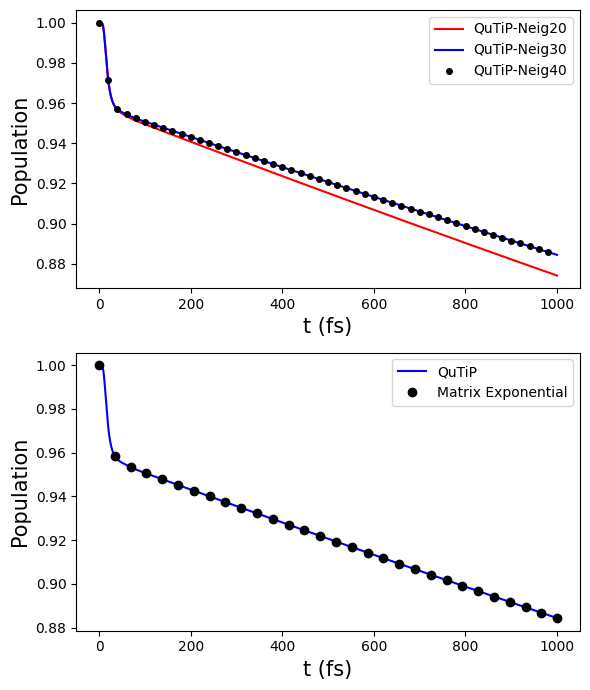

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))
axs[0].plot(time_qtp*pa.au2fs,result_qtp[20][0],'r-',label = 'QuTiP-Neig20')
axs[0].plot(time_qtp*pa.au2fs,result_qtp[30][0],'b-',label = 'QuTiP-Neig30')
axs[0].plot(time_qtp*pa.au2fs,result_qtp[40][0],'ko',markersize=4,markevery=400,label = 'QuTiP-Neig40')
axs[0].set_xlabel('t (fs)',fontsize=15)
axs[0].set_ylabel('Population',fontsize=15)
axs[0].legend(loc = 'upper right')

#plt.figure(figsize=(6,3))
axs[1].plot(time_qtp*pa.au2fs,result_qtp[30][0],'b-',label = 'QuTiP')
axs[1].plot(time_short*pa.au2fs,result_s.expect[:],'ko',label = 'Matrix Exponential')
axs[1].set_xlabel('t (fs)',fontsize=15)
axs[1].set_ylabel('Population',fontsize=15)
axs[1].legend(loc = 'upper right')

plt.tight_layout()

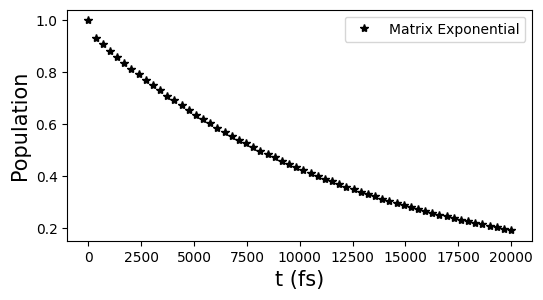

In [35]:
plt.figure(figsize=(6,3))
plt.plot(time_long*pa.au2fs,result_dw_l.expect,'k*',label = 'Matrix Exponential')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')

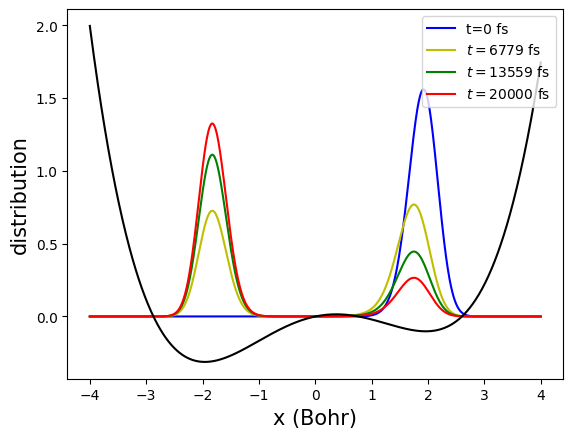

In [36]:
#extract the distribution
dis_list = []
for nn in [0,20,40,59]:
  rho = result_dw_l.density_matrix[nn]
  rho_grid = np.matmul(np.matmul(psi_DW[:,:N_eig_use],rho),psi_DW[:,:N_eig_use].conj().T)
  dis_list.append(rho_grid.diagonal().real)

#plot
plt.plot(xgrid,dis_list[0],'b',label='t=0 fs')
plt.plot(xgrid,dis_list[1],'y',label=rf'$t={{{int(time_long[20]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[2],'g',label=rf'$t={{{int(time_long[40]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,dis_list[3],'r',label=rf'$t={{{int(time_long[59]*pa.au2fs)}}}$ fs')
plt.plot(xgrid,pot_arr*10,'k')
plt.xlabel('x (Bohr)',fontsize=15)
plt.ylabel('distribution',fontsize=15)
plt.legend(loc = 'upper right')

## Quantum simulation of the Double Well

In [37]:
def expand(Gmat_org,Norg,Nexpand):
  Gnew = np.zeros((Nexpand**2,Nexpand**2),dtype=np.complex_)
  for i in range(Norg):
    for j in range(Norg):
      for k in range(Norg):
        for l in range(Norg):
            Gnew[i*Nexpand+j,k*Nexpand+l] = Gmat_org[i*Norg+j,k*Norg+l]
  return Gnew

dim_dw = 32
Nqb_dw = int(np.log2(dim_dw))

#extract the propagator from result of classical simulation
Gprop_dw = []
for i in range(len(result_dw_l.Gprop)):
    org_dim = result_dw_l.density_matrix[i].shape[0]
    Gprop_dw.append(expand(result_dw_l.Gprop[i],org_dim,dim_dw))

In [38]:
#For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

Kraus_all = {}
for i0 in range(nsteps):

    i = i0*ilarge
    print('istep',i0)

    #get the kraus operators from the propagator
    Kraus_all[i0] = gen_Kraus_list(Gprop_dw[i],dim_dw,tol=1E-2)

istep 0
istep 1
istep 2
istep 3
istep 4
istep 5
istep 6
istep 7
istep 8
istep 9
istep 10
istep 11


In [39]:
# initial state of the double-well in the dilated space
ini_occu = np.zeros(dim_dw,dtype=np.complex_)
ini_occu[5] = 1.0
stat0_dil = np.concatenate((ini_occu,np.zeros(dim_dw)))

In [40]:
from qiskit.quantum_info import SparsePauliOp

#decompose the dilated space observable into summation of tensor product of pauli matrices
Obs_mat = np.zeros((2*dim_dw,2*dim_dw),dtype=np.complex_)
Obs_mat[:dim_dw,:dim_dw] = P_R_eig[:dim_dw,:dim_dw]
Obs_paulis_dic = ham_to_pauli(Obs_mat, Nqb_dw+1, tol=5E-3)

#Prepare the qiskit observable from the pauli strings of observable matrix
data = []
coef = []
for key in Obs_paulis_dic:
  data.append(key)
  coef.append(Obs_paulis_dic[key])
obs_q = SparsePauliOp(data,coef)

In [41]:
#this section will take about 20 minutes

from qiskit_aer.primitives import Estimator

#Aer implementation of an Estimator
estimator = Estimator()

shots = 2000

#For saving calculation, only choose some time points
ilarge = 5
nsteps = int(len(Gprop_dw)/ilarge)

time_dw_qc = np.zeros((nsteps),dtype=np.float_)
P_dw_qc = np.zeros((nsteps),dtype=np.float_)
for i0 in range(nsteps):

    i = i0*ilarge
    print('istep',i0,'in total', nsteps)

    time_dw_qc[i0] = time_long[i]

    matKraus_list = Kraus_all[i0]
    print('number of Kraus opeartors',len(matKraus_list))

    for ikraus in range(len(matKraus_list)):

      # Create the quantum circuit
      qr = QuantumRegister(Nqb_dw+1)
      cr = ClassicalRegister(Nqb_dw+1)
      qc = QuantumCircuit(qr, cr)

      # Initialize the quantum circuit with the initial state
      qc.initialize(stat0_dil, qr)

      # Create a custom unitary operator with the dilated Kraus propagator
      UM = dilate(matKraus_list[ikraus],Isscale=False)
      UM_op = Operator(UM)

      # Apply the unitary operator to the quantum circuit's qubits
      qc.unitary(UM_op, qr)

      result = estimator.run(qc, obs_q, shots = shots).result()
      P_dw_qc[i0] += result.values[0]


istep 0 in total 12
number of Kraus opeartors 1
istep 1 in total 12
number of Kraus opeartors 78
istep 2 in total 12
number of Kraus opeartors 76
istep 3 in total 12
number of Kraus opeartors 77
istep 4 in total 12
number of Kraus opeartors 76
istep 5 in total 12
number of Kraus opeartors 77
istep 6 in total 12
number of Kraus opeartors 77
istep 7 in total 12
number of Kraus opeartors 75
istep 8 in total 12
number of Kraus opeartors 75
istep 9 in total 12
number of Kraus opeartors 73
istep 10 in total 12
number of Kraus opeartors 76
istep 11 in total 12
number of Kraus opeartors 76


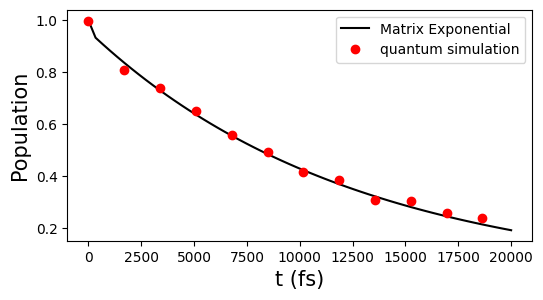

In [42]:
plt.figure(figsize=(6,3))
plt.plot(time_long*pa.au2fs,result_dw_l.expect,'k-',label = 'Matrix Exponential')
plt.plot(time_dw_qc*pa.au2fs,P_dw_qc,'ro',label = 'quantum simulation')
plt.xlabel('t (fs)',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.legend(loc = 'upper right')